Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


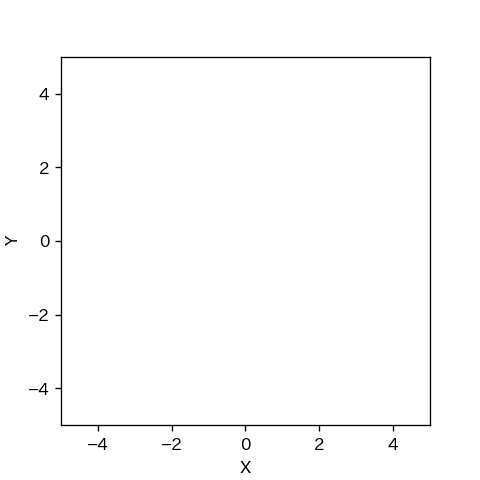

In [2]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [4]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [5]:
def trial(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [6]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

0 真値: [-1.20471748  2.33230504  4.12081001] 推定値: [-1.24680393  2.68106302  4.22539518] 誤差: 0.3512881942918028
1
1 真値: [-3.85358059 -3.97387951  4.52230088] 推定値: [ 0.39805367 -1.60623079  4.97649489] 誤差: 4.866431374304203
2 真値: [-3.41329597 -4.87096516  6.43832891] 推定値: [ 5.81081178 -4.62307317  2.60847703] 誤差: 9.227438112562048
3 真値: [-0.46195718  3.07779075  6.75253282] 推定値: [-0.27158917  3.02540514  0.56503405] 誤差: 0.19744424779999706
2
4 真値: [-2.76933171 -2.75026043  5.93170556] 推定値: [-2.98723734 -4.73719044  0.03477357] 誤差: 1.9988430926085865
5 真値: [1.30343469 0.04207517 7.77527753] 推定値: [ 1.565675   -0.09756391  1.53270898] 誤差: 0.2971010865430756
3
6 真値: [-2.53425889  3.40968373  7.72329882] 推定値: [ 2.84477941 -1.81322879  2.68619238] 誤差: 7.4975241458628155
7 真値: [2.61928495 3.82681226 2.90491079] 推定値: [2.80224733 3.97202012 2.77483849] 誤差: 0.2335820125373945
4
8 真値: [4.88319901 6.34470947 3.90738246] 推定値: [-0.19750945  2.79225566  6.06160819] 誤差: 6.199477922370278
9 真値: [-3.249116

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [0.73492504 2.03236887 5.50673061] 推定値: [ 4.21118064  2.47374854 -1.392841  ] 誤差: 3.5041645279820433
21 真値: [1.79701471 1.10490733 5.39313626] 推定値: [ 1.49048261  0.99909202 -0.84273476] 誤差: 0.32428199517493755
13
22 真値: [-4.87749358  4.56571195  3.96271304] 推定値: [-4.52423106  3.62922173  4.65019125] 誤差: 1.0009037661298452
23 真値: [3.48220237 4.44073265 8.52527227] 推定値: [4.27785443 4.69570338 1.97884647] 誤差: 0.835507195047064
14
24 真値: [-1.43249866  5.29808943  5.31031844] 推定値: [-1.35883312  5.36306907 -0.99046409] 誤差: 0.09822914704056476
15
25 真値: [2.34070891 0.37979534 3.54140261] 推定値: [1.75564703 0.70847263 3.12896937] 誤差: 0.6710634615400201
16
26 真値: [-2.78553253  1.38823404  6.6843375 ] 推定値: [-2.89997389  1.06743911  6.56854329] 誤差: 0.34059684870363116
17
27 真値: [-3.23323866 -4.49161025  7.39169066] 推定値: [ 3.49824213  3.10874965 -0.99638568] 誤差: 10.152748614099606
28 真値: [-6.3629041  -1.42556713  4.88165311] 推定値: [-5.37944106 -1.69848647  4.90950324] 誤差: 1.0206294629372596
29